## Reconstruction

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

In [2]:
def sand_mask(img):
    ''' detect sand regions '''
    # blur image and convert to hsv space
    blur = cv2.blur(img, (9,9))
    hsv = cv2.cvtColor(blur, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)

    # Otsu's thresholding using v space
    ret,mask1 = cv2.threshold(v,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    kernel = np.ones((25,25),np.uint8)
    mask1 = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, kernel)
    
    contours, hier = cv2.findContours(mask1,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 1:
        largest = max(contours, key = cv2.contourArea)
        mask1 = cv2.drawContours(mask1, [largest], 0, 255, -1)

        
    #find black area
    mask2 = cv2.inRange(h,100,110)
    
    # closing to remove small holes
    kernel = np.ones((15,15),np.uint8)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_CLOSE, kernel)
    mask2 = cv2.morphologyEx(mask2, cv2.MORPH_OPEN, kernel)

    # apply masks to the image
    mask = cv2.bitwise_and(mask1,~mask2)
  
    contours2, hier2 = cv2.findContours(mask,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
        
    for c in contours2:
        mask = cv2.drawContours(mask, [c], 0, 0, -1)
    largest = max(contours2, key = cv2.contourArea)
    mask = cv2.drawContours(mask, [largest], 0, 255, -1)
    
    # find yellow area
    mask3 = cv2.inRange(hsv,np.array([19,120,0]),np.array([23,200,255]))
    mask = cv2.bitwise_and(mask,~mask3)
    
    kernel = np.ones((15,15),np.uint8)
    expanded = cv2.erode(mask, kernel)
    
    return mask, expanded

In [3]:
def find_keypoints(img, mask):
    ''' find feature points for an image in area of mask'''
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    fast = cv2.FastFeatureDetector_create()
    br = cv2.BRISK_create()
    # find the keypoints with FAST, use mask to specify region
    kp = fast.detect(gray, mask)
    # compute descriptors with BRISK
    kp, des = br.compute(gray, kp)
    
    return kp, des

In [4]:
def match_keypoints(kp1, des1, kp2, des2):
    ''' match keypoints,
        return point locations and descriptors'''
    # compute matches with Brute-Force Matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # match descriptors
    matches = bf.match(des1,des2)
    # sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)

    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1,1,2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1,1,2) 
    des = np.float32([des1[m.queryIdx] for m in matches])

    
    return src_pts, dst_pts, des

In [5]:
class MapPoint:
    ''' Class for points for which we already calculated the 3D position,
        store descriptor and 3D location of point'''
    def __init__(self, descriptor, pos3D):
        self.descriptor = descriptor
        self.pos3D = pos3D
    
    def updatePos(self, pos3D):
        self.pos3D = pos3D

In [6]:
class KeyFrame:
    ''' Class for keyframes,
        store rotation R, translation T of camera, intrinsic camera matrix K, indices of observed points, projected 2d points '''
    def __init__(self, R, T, K, width, height, observed, points2D):
        self.R = R
        self.T = T
        self.K = K
        self.width = width
        self.height = height
        self.observed = observed
        self.points2D = points2D
    
    def updateCamera(self, R, T, K):
        self.R = R
        self.T = T
        self.K = K

In [7]:
def find_mapped(map_pts, des):
    ''' Find points which were already triangulated in given descriptor list, return indices'''
    mapped = []
    for i in range(len(map_pts)):
        mapped.append(map_pts[i].descriptor)
        
    mapped = np.uint8(mapped)
    des = np.uint8(des)

    # compute matches with Brute-Force Matcher
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    # match descriptors

    matches = bf.match(mapped,des)
    
    # sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)

    # find indices of those points
    map_idx = [m.queryIdx for m in matches]
    des_idx = [m.trainIdx for m in matches]
    return map_idx, des_idx

In [8]:
def updateParams(frames, triangulated, rotations, translations, intrinsics, points):
    '''Update rotation, translation and intrinsic matrices for all cameras, 3D positions of triangulated points'''
    
    for i in range(len(frames)):
        R = rotations[i]
        T = translations[i]
        K = intrinsics[i]
        
        frames[i].updateCamera(R, T, K)
    
    for i in range(len(triangulated)):
        pos = points[i]
        triangulated[i].updatePos(pos)

Original:


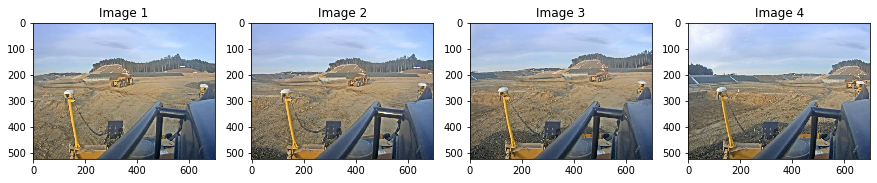

In [9]:
img1 = cv2.imread(r'C:\Users\SKO1SBY\Documents\sand_video\frame30.jpg')
img2 = cv2.imread(r'C:\Users\SKO1SBY\Documents\sand_video\frame60.jpg')
img3 = cv2.imread(r'C:\Users\SKO1SBY\Documents\sand_video\frame90.jpg')
img4 = cv2.imread(r'C:\Users\SKO1SBY\Documents\sand_video\frame120.jpg')
rgb1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
rgb2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
rgb3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)
rgb4 = cv2.cvtColor(img4, cv2.COLOR_BGR2RGB)

print('Original:')

plt.figure(figsize=(15,5))
plt.subplot(141),plt.title("Image 1"),plt.imshow(rgb1)
plt.subplot(142),plt.title("Image 2"),plt.imshow(rgb2)
plt.subplot(143),plt.title("Image 3"),plt.imshow(rgb3)
plt.subplot(144),plt.title("Image 4"),plt.imshow(rgb4)
plt.show()

In [10]:
# detect sand regions
mask1, exp1 = sand_mask(img1)
mask2, exp2 = sand_mask(img2)
mask3, exp3 = sand_mask(img3)
mask4, exp4 = sand_mask(img4)
sand1 = cv2.bitwise_and(rgb1,rgb1,mask=mask1)
sand2 = cv2.bitwise_and(rgb2,rgb2,mask=mask2)
sand3 = cv2.bitwise_and(rgb3,rgb3,mask=mask3)
sand4 = cv2.bitwise_and(rgb4,rgb4,mask=mask4)

In [11]:
# list of triangulated points
triangulated = []
# list of frames/views
frames = []

__Reconstruction for image1 and image2:__

In [12]:
kp1, des1 = find_keypoints(img1, exp1)
kp2, des2 = find_keypoints(img2, exp2)


src_pts, dst_pts, des = match_keypoints(kp1, des1, kp2, des2)

# src_pts, dst_pts = match_features(sand1, exp1, sand2, exp2)

H, warp_mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

#find fundamental matrix
F, f_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 5.0)
# select only inliers
src_pts = src_pts[f_mask.ravel()==1]
dst_pts = dst_pts[f_mask.ravel()==1]
des = des[f_mask.ravel()==1]

    

# assumption: focal length = 1, principal point = image center, skew = 0
h, w = sand1.shape[:2]
intrinsic = np.array([[1,0,int(w/2)],[0,1,int(h/2)],[0,0,1]], np.float64)

# find essential matrix
E, e_mask = cv2.findEssentialMat(src_pts, dst_pts, intrinsic, cv2.RANSAC, 0.99)

# E = np.dot(intrinsic.T, np.dot(F,intrinsic))
# print(E)

# #find fundamental matrix
# F, f_mask = cv2.findFundamentalMat(src_pts, dst_pts, cv2.FM_RANSAC, 5.0)
# # select only inliers
# src_pts = src_pts[f_mask.ravel()==1]
# dst_pts = dst_pts[f_mask.ravel()==1]

# camera 1
R1 = np.eye(3)
T1 = np.array([0,0,0], np.float64)

# find rotation, translation for camera 2
retval, R2, T2, r_mask = cv2.recoverPose(E, src_pts, dst_pts)

# get camera projection matrices
RT1 = np.c_[R1, T1]
RT2 = np.c_[R2, T2]
P1 = np.dot(intrinsic,RT1)
P2 = np.dot(intrinsic,RT2)

# triangulate points
points4D = cv2.triangulatePoints(P1, P2, src_pts, dst_pts)
points4D = np.transpose(points4D)
points3D = cv2.convertPointsFromHomogeneous(points4D)
points3D = points3D.squeeze()

# get the color of each reconstructed point
color1 = np.float64([sand1[int(x[0,1]), int(x[0,0])]/255 for x in src_pts])

Reprojected points:


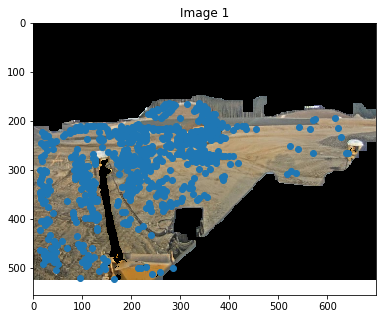

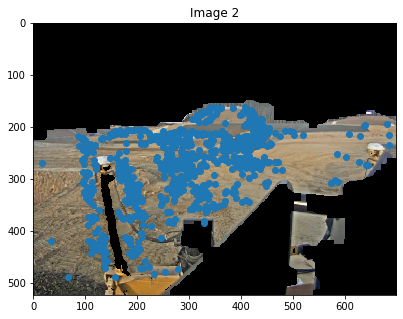

In [13]:
print("Reprojected points:")

projected1, jacobian1 = cv2.projectPoints(points3D, R1, T1, intrinsic, None)
plt.figure(figsize=(10,5))
plt.title("Image 1")
plt.imshow(sand1)
plt.scatter(projected1[:,0,0],projected1[:,0,1])
plt.show()

projected2, jacobian2 = cv2.projectPoints(points3D, R2, T2, intrinsic, None)
plt.figure(figsize=(10,5))
plt.title("Image 2")
plt.imshow(sand2)
plt.scatter(projected2[:,0,0],projected2[:,0,1])
plt.show()

In [14]:
error = 0
errors = []
for i in range(len(points3D)):
    # points on image 1
    dist1 = cv2.norm(src_pts[i],projected1[i]) ** 2
    error += dist1
    errors.append(dist1)
    # points on image 2
    dist2 = cv2.norm(dst_pts[i],projected2[i]) ** 2
    error += dist2
    errors.append(dist2)

print("Reprojection error: ", error)

Reprojection error:  12573.587119633667


In [15]:
# add points to list of triangulated points
for i in range(len(points3D)):
    pt = MapPoint(des[i],points3D[i])
    triangulated.append(pt)
    
# add frames to list of frames
frame1 = KeyFrame(R1,T1,intrinsic,w,h,np.arange(len(points3D)),src_pts)
frame2 = KeyFrame(R2,T2,intrinsic,w,h,np.arange(len(points3D)),dst_pts)
frames.append(frame1)
frames.append(frame2)

In [16]:
center1 = np.dot(-R1.T, T1)
center2 = np.dot(-R2.T, T2)

<IPython.core.display.Javascript object>


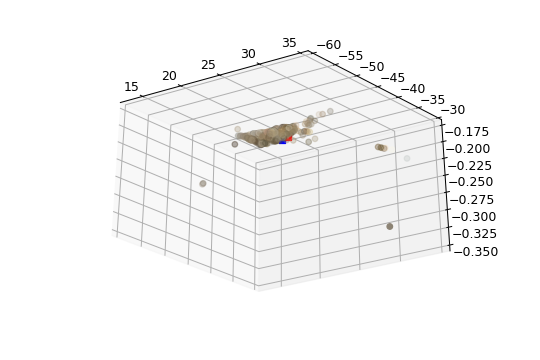

In [18]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(points3D[:,0], points3D[:,1], points3D[:,2], c=color1)
ax.scatter3D(center1[0],center1[1],center1[2],marker='s',c='red')
ax.scatter3D(center2[0],center2[1],center2[2],marker='s',c='blue')
plt.show()

red, blue: camera positions

#### Bundle Adjustment:

Minimize error function:


$\min_{a_j,b_i} \sum_{i=1}^{n} \sum_{j=1}^{m} v_{ij} d(Q(a_j, b_i), x_{ij})^2$


where:
- $Q(a_j, b_i)$ is the predicted projection of point $i$ on image $j$
- $d(x,y)$ denotes the Euclidean distance between image points
- $v_{ij} = \left\{
        \begin{array}\\
            1 & \mbox{if point $i$ is visible in image $j$}\\
            0 & \mbox{otherwise}
        \end{array}
     \right.$

In [19]:
from scipy.optimize import least_squares
from scipy.sparse import lil_matrix

class BA:
    '''class for bundle adjustment'''
    
    def __init__(self, n_cameras, n_points, frames, triangulated):
        '''Initialize class variables'''
        
        # number of cameras
        self.n_cameras = n_cameras
        # number of 3D points
        self.n_points = n_points
        
        # initial estimates of parameters for all cameras (7 parameters for each camera, where the first 3 are for rotation, the next 3 for translation and the last for focal length)
        self.camera_params = np.empty(n_cameras * 7)
        for i in range(n_cameras):
            R = frames[i].R
            x,y,z = self.rotationToEuler(R)
            self.camera_params[0 + (i * 7) : 3 + (i * 7)] = x,y,z
            T = frames[i].T
            self.camera_params[3 + (i * 7) : 6 + (i * 7)] = T[0], T[1], T[2]
            K = frames[i].K
            self.camera_params[6 + (i * 7)] = K[0,0]
        self.camera_params = self.camera_params.reshape((n_cameras, -1))
        
        # initial estimates of 3D point coordinates
        self.points_3d = np.empty((n_points, 3))
        for i in range(n_points):
            self.points_3d[i] = triangulated[i].pos3D
            
        # number of projected points
        n_observations = 0
        for i in range(n_cameras):
            n_observations += len(frames[i].observed)
            
        # indices of cameras/points involved in each observation, observed 2D coordinates
        self.camera_idx = np.empty((n_observations), dtype=int)
        self.point_idx = np.empty((n_observations), dtype=int)
        self.points_2d = np.empty((n_observations, 2))
        
        i = 0
        for j in range(n_cameras):
            observed = frames[j].observed
            points2D = frames[j].points2D
            for k in range(len(observed)):
                self.camera_idx[i] = j
                self.point_idx[i] = observed[k]
                self.points_2d[i] = points2D[k]
                i += 1
                
        # width, height of each image plane
        self.w = np.empty(n_cameras)
        self.h = np.empty(n_cameras)
        for i in range(n_cameras):
            self.w[i] = frames[i].width
            self.h[i] = frames[i].height
                        
    
    def rotationToEuler(self, R):
        sy = np.sqrt(R[0,0]**2 +  R[1,0]**2)
        singular = sy < 1e-6
    
        if not singular:
            x = np.arctan2(R[2,1], R[2,2])
            y = np.arctan2(-R[2,0], sy)
            z = np.arctan2(R[1,0], R[0,0])
        else:
            x = np.arctan2(-R[1,2], R[1,1])
            y = np.arctan2(-R[2,0], sy)
            z = 0
    
        return x,y,z


    def eulerToRotation(self, x, y, z) :
        Rx = np.array([[1, 0, 0],
                       [0, np.cos(x), -np.sin(x)],
                       [0, np.sin(x), np.cos(x)]])
    
        Ry = np.array([[np.cos(y), 0, np.sin(y)],
                       [0, 1, 0],
                       [-np.sin(y), 0, np.cos(y)]])
    
        Rz = np.array([[np.cos(z), -np.sin(z), 0],
                       [np.sin(z), np.cos(z), 0],
                       [0, 0, 1]])

        R = np.dot(Rz, np.dot(Ry, Rx))

        return R

    
    def project(self, points, camera_params, w, h):
        ''' Project points to image planes for given camera parameters'''
        
        rotations = camera_params[:, :3]
        translations = camera_params[:, 3:6]
        f = camera_params[:, 6]
    
        projected = np.empty((len(points), 2))
    
        for i in range(len(points)):
            # world to camera coordinates
            x, y, z = rotations[i]
            R = self.eulerToRotation(x,y,z)
            T = translations[i]
            RT = np.c_[R, T]
            p = np.dot(RT, np.append(points[i], 1))
        
            # camera to pixel coordinates
            K = np.array([[f[i],0,int(w[i]/2)],[0,f[i],int(h[i]/2)],[0,0,1]], np.float64)
            p = np.dot(K, p)
            # back to euclidean from homogeneous
            p = [p[0]/p[2], p[1]/p[2]]
        
            projected[i] = p
    
        return projected
    
    
    def fun(self, params, n_cameras, n_points, camera_idx, point_idx, points_2d):
        '''Compute residuals,
           params contains camera parameters and 3-D coordinates'''
        
        camera_params = params[:n_cameras * 7].reshape((n_cameras, 7))
        points_3d = params[n_cameras * 7:].reshape((n_points, 3))
        points_proj = self.project(points_3d[point_idx], camera_params[camera_idx], self.w[camera_idx], self.h[camera_idx])
        return (points_proj - points_2d).ravel()
    
    
    def jacobian(self, n_cameras, n_points, camera_idx, point_idx):
        m = camera_idx.size * 2
        n = n_cameras * 7 + n_points * 3
        A = lil_matrix((m, n), dtype=int)

        i = np.arange(camera_idx.size)
        for s in range(9):
            A[2 * i, camera_idx * 7 + s] = 1
            A[2 * i + 1, camera_idx * 7 + s] = 1

        for s in range(3):
            A[2 * i, n_cameras * 7 + point_idx * 3 + s] = 1
            A[2 * i + 1, n_cameras * 7 + point_idx * 3 + s] = 1

        return A
    
    
    def optimizedParams(self, params):
        '''Retrieve optimized camera parameters and 3D coordinates'''

        camera_params = params[:self.n_cameras * 7].reshape((self.n_cameras, 7))
        points_3d = np.float32(params[self.n_cameras * 7:].reshape((self.n_points, 3)))
        
        rotations = np.empty((self.n_cameras, 3, 3))
        translations = np.empty((self.n_cameras, 3))
        intrinsics = np.empty((self.n_cameras, 3, 3))
        
        for i in range(self.n_cameras):
            x, y, z = camera_params[i, :3]
            rotations[i] = self.eulerToRotation(x,y,z)
            translations[i] = camera_params[i, 3:6]
            f = camera_params[i, 6]
            w = self.w[i]
            h = self.h[i]
            intrinsics[i] = np.array([[f,0,int(w/2)],[0,f,int(h/2)],[0,0,1]], np.float64)

        return rotations, translations, intrinsics, points_3d
    
    
    def bundle_adjust(self):
        ''' Perform bundle adjustment, return optimized parameters'''
        
        x0 = np.hstack((self.camera_params.ravel(), self.points_3d.ravel()))
        A = self.jacobian(self.n_cameras, self.n_points, self.camera_idx, self.point_idx)
        
        # solve nonlinear least-squares problem
        res = least_squares(self.fun, x0, jac_sparsity=A, verbose=2, x_scale='jac', ftol=1e-4, method='trf',
                    args=(self.n_cameras, self.n_points, self.camera_idx, self.point_idx, self.points_2d))
        
        Rs, Ts, Ks, points = self.optimizedParams(res.x)
        
        return Rs, Ts, Ks, points

In [20]:
n_cameras = len(frames)
n_points = len(triangulated)

print("n_cameras: {}".format(n_cameras))
print("n_points: {}".format(n_points))

n_cameras: 2
n_points: 708


In [21]:
ba = BA(n_cameras, n_points, frames, triangulated)
rotations, translations, intrinsics, points3d = ba.bundle_adjust()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         6.2868e+03                                    8.72e+06    
       1              4         4.6975e+03      1.59e+03       3.39e+01       1.41e+07    
       2              5         2.8220e+03      1.88e+03       1.55e+01       5.11e+06    
       3              6         2.3087e+03      5.13e+02       5.76e+01       1.56e+06    
       4              7         1.8994e+03      4.09e+02       4.80e+01       7.73e+06    
       5              8         1.8444e+03      5.50e+01       1.54e+02       1.87e+07    
       6              9         1.6781e+03      1.66e+02       5.44e+00       4.04e+05    
       7             10         1.6660e+03      1.21e+01       3.37e+01       7.34e+05    
       8             12         1.6598e+03      6.25e+00       1.72e+01       2.74e+05    
       9             13         1.6546e+03      5.18e+00       3.45e+01       8.45e+05    

In [22]:
updateParams(frames, triangulated, rotations, translations, intrinsics, points3d)

In [23]:
projected1, jacobian1 = cv2.projectPoints(points3d, frames[0].R, frames[0].T, frames[0].K, None)
projected2, jacobian2 = cv2.projectPoints(points3d, frames[1].R, frames[1].T, frames[1].K, None)

In [24]:
error = 0
for i in range(len(points3d)):
    # points on image 1
    dist1 = cv2.norm(src_pts[i],projected1[i]) ** 2
    error += dist1
    # points on image 2
    dist2 = cv2.norm(dst_pts[i],projected2[i]) ** 2
    error += dist2

print("Reprojection error: ", error)

Reprojection error:  3214.1707921625657


- reprojection error became much smaller after bundle adjustment

In [25]:
rem_ind = []
for i in range(len(points3d)):
    # points on image 1
    dist1 = cv2.norm(src_pts[i],projected1[i]) ** 2
    if dist1 > 1:
        rem_ind.append(i)
    else:
        # points on image 2
        dist2 = cv2.norm(dst_pts[i],projected2[i]) ** 2
        if dist2 > 1:
            rem_ind.append(i)
            
src_pts = np.delete(src_pts, rem_ind, axis=0)
dst_pts = np.delete(dst_pts, rem_ind, axis=0)
projected1 = np.delete(projected1, rem_ind, axis=0)
projected2 = np.delete(projected2, rem_ind, axis=0)
points3d = np.delete(points3d, rem_ind, axis=0)
color1 = np.delete(color1, rem_ind, axis=0)

Reprojected points after removing outliers:


<IPython.core.display.Javascript object>


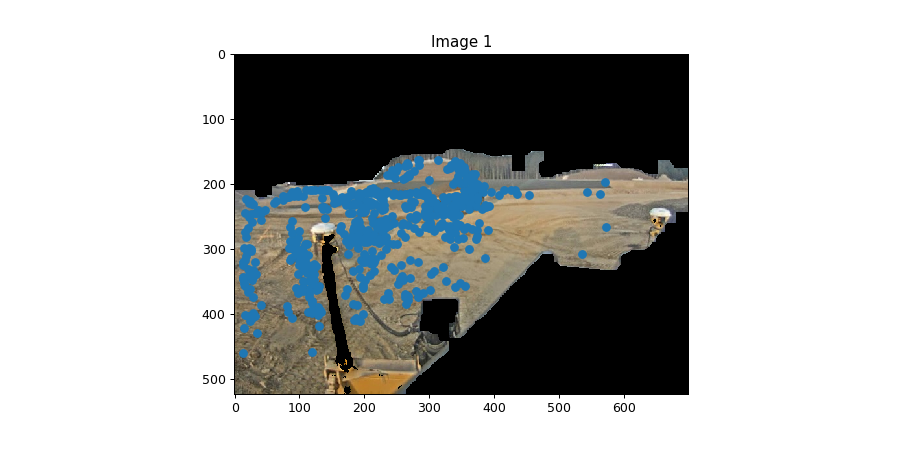

<IPython.core.display.Javascript object>


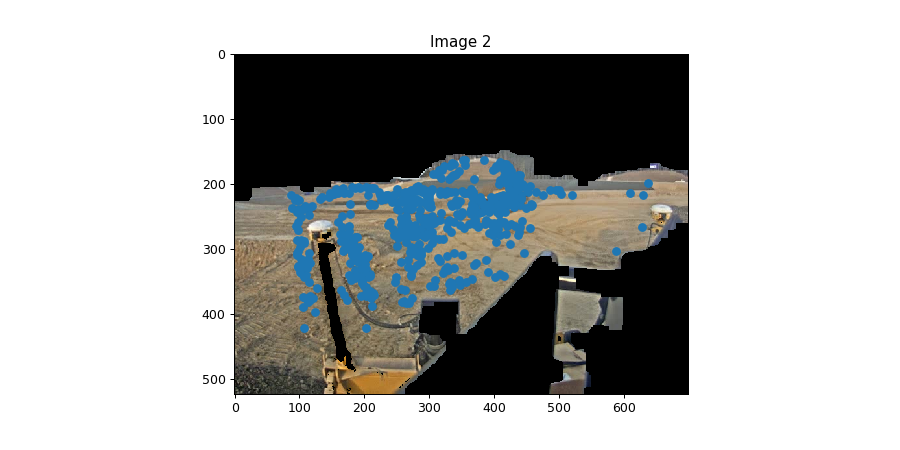

In [26]:
print("Reprojected points after removing outliers:")

plt.figure(figsize=(10,5))
plt.title("Image 1")
plt.imshow(sand1)
plt.scatter(projected1[:,0,0],projected1[:,0,1])
plt.show()

plt.figure(figsize=(10,5))
plt.title("Image 2")
plt.imshow(sand2)
plt.scatter(projected2[:,0,0],projected2[:,0,1])
plt.show()

<IPython.core.display.Javascript object>


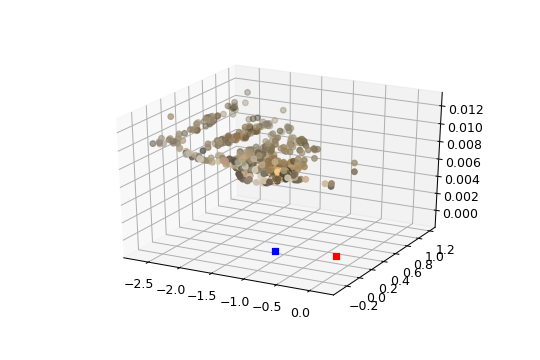

In [27]:
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection="3d")

ax.scatter3D(points3d[:,0], points3d[:,1], points3d[:,2], c=color1)
ax.scatter3D(center1[0],center1[1],center1[2],marker='s',c='red')
ax.scatter3D(center2[0],center2[1],center2[2],marker='s',c='blue')
plt.show()